In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [1]:
colors = {
    'red':    '#EC4C4C',   # Light Crimson
    'green':  '#70D07C',   # Clean Apple Green
    'blue':   '#4C9CED',   # Bright Steel Blue
    'yellow': '#FFC857'    # Golden Sun
}

np.random.seed(428)

NameError: name 'np' is not defined

In [14]:
@dataclass
class GenerationResult:
    s: any
    q: any
    w: any
    s_prime: any
    q_prime: any
    cov_ws: any
    cov_wq: any
    cov_wq_est_max: any
    rho_sq: any
    rho_sq_est: any
    rho_wq: any
    rho_ws: any
    s_hat: any
    s_hat_est: any
    E_ws: any
    E_wq: any
    E_wq_est_lin: any
    E_wq_est_phi_bar: any
    delta_s_bar: any
    delta_q_bar: any
    ratio_s: any
    ratio_q: any
    QSC: any
    QSC_ratio: any

# phi params
a = 2
b = 4

def lin_phi_bar(z):
    return a * z**2 + b

def lin_phi(z, s_hat):
    s_hat_sq = s_hat**2
    # Calculate noise variance such that the correlation between phi_bar(z) and z is s_hat.
    sigma_noise = np.sqrt((s_hat_sq**-1 - 1) * np.var(lin_phi_bar(z)))
    noise = np.random.normal(loc=0, scale=sigma_noise, size=z.shape)
    return lin_phi_bar(z) + noise

def lin_phi_inv(q):
    return (q - b) / a

def noise(k, mu, sigma):
    return lambda z: (k * z) + mu + np.random.normal(0, sigma, z.shape[0])

def fitness(k, mu, sigma):
    return lambda z: (z - mu) * k + np.random.normal(0, sigma, z.shape[0])

def logistic_fitness(k, s_opt):
    return lambda s: 1 / (1 + np.exp(-k * (s - s_opt)))

def delta(mu, sigma):
    return lambda z: np.random.normal(mu, sigma, z.shape[0])

def simulate_generation(
        s,      # number of individuals
        phi=lin_phi,
        phi_bar=lin_phi_bar,
        s_hat = 0.8,
        delta_fn=noise(0, 0, .1),
        fitness_fn=fitness(.5, 0, .2)
):
    w_abs = w = fitness_fn(s)
    w_min = np.min(w)

    if w_min < 0:
        w = w - w_min

    w = w / np.sum(w)

    q = phi(s, s_hat)

    # Compute covariances and correlations
    cov_ws = np.cov(w, s, bias=True)[0, 1]
    cov_wq = np.cov(w, q, bias=True)[0, 1]
    rho_sq = np.corrcoef(s, q)[0, 1]        # correlation between s and q (estimated fidelity)
    rho_wq = np.corrcoef(w, q)[0, 1]
    rho_ws = np.corrcoef(w, s)[0, 1]
    s_hat_est = np.sqrt(np.var(phi_bar(s)) / np.var(q))

    delta_s = delta_fn(s)

    # Transmission: simulate Δs as mutation noise and compute Δq from the mapping
    E_ws = np.mean(w * delta_s)

    # Δq computed as the difference between the noisy mapping and the baseline phi_bar of the mean s.
    delta_q = phi(s + delta_s, s_hat) - phi(s, s_hat)
    delta_q_phi_bar = phi_bar(s + delta_s) - phi_bar(s)

    # Compute expected fitness-weighted Δq (both from simulation and the expected linear component)
    E_wq = np.mean(w * delta_q)
    E_wq_est_lin = np.mean(w * (a * delta_s))  # since d(phi_bar)/dz = a for linear phi_bar
    E_wq_est_phi_bar = np.mean(w * delta_q_phi_bar)  # since d(phi_bar)/dz = a for linear phi_bar

    delta_s_bar = cov_ws + E_ws
    delta_q_bar = cov_wq + E_wq

    s_prime = np.random.choice(s, size=s.shape[0], p=w) + delta_s
    q_prime = phi(s_prime, s_hat)

    return GenerationResult(
        s=s,
        q=q,
        w=w_abs,
        s_prime=s_prime,
        q_prime=q_prime,
        cov_ws=cov_ws,
        cov_wq=cov_wq,
        cov_wq_est_max=rho_sq * np.sqrt(np.var(w) * np.var(q)),
        rho_sq=rho_sq,
        rho_sq_est=rho_wq / rho_ws,
        rho_wq=rho_wq,
        rho_ws=rho_ws,
        s_hat=s_hat,
        s_hat_est=s_hat_est,
        E_ws=E_ws,
        E_wq=E_wq,
        E_wq_est_lin=E_wq_est_lin,
        E_wq_est_phi_bar=E_wq_est_phi_bar,
        delta_s_bar=delta_s_bar,
        delta_q_bar=delta_q_bar,
        ratio_s=E_ws/cov_ws,
        ratio_q=E_wq/cov_wq,
        QSC=E_wq / (np.sqrt(np.var(w) * np.var(q))),
        QSC_ratio=E_wq / np.sqrt(np.var(w) * np.var(q)) / s_hat,
    )

@dataclass
class GenerationsResult:
    generations: int
    results: any
    last_result: any
    s_means: any
    s_stds: any
    q_means: any
    q_stds: any
    w_means: any
    w_stds: any
    rho_sq_means: any

def simulate_generations(generations=100, n=10_000, s_hat=.5, **kwargs):
    s = np.random.normal(0, 1, n)

    results = []
    s_means = []
    s_stds = []
    q_means = []
    q_stds = []
    w_means = []
    w_stds = []

    for g in range(generations):
        r = simulate_generation(s_hat=s_hat, s=s, **kwargs)
        s = r.s_prime
        s_means.append(np.mean(r.s_prime))
        s_stds.append(np.std(r.s_prime))
        q_means.append(np.mean(r.q_prime))
        q_stds.append(np.std(r.q_prime))
        w_means.append(np.mean(r.w))
        w_stds.append(np.std(r.w))

        if g % ((generations // 50)+1) == 0:
            results.append(r)
            print(f"Generation {g}", end='\r')

    return GenerationsResult(
        generations=generations,
        results=results,
        last_result=r,
        s_means=np.array(s_means),
        s_stds=np.array(s_stds),
        q_means=np.array(q_means),
        q_stds=np.array(q_stds),
        w_means=np.array(w_means),
        w_stds=np.array(w_stds),
        rho_sq_means=np.corrcoef(gr.s_means, gr.q_means)[0, 1]
    )

In [10]:
def display_s_vs_q(r, sample_size = 600, filename=None):
    indices = np.random.choice(r.s.shape[0], sample_size, replace=False)
    s_sample = r.s[indices]
    q_sample = r.q[indices]
    w_sample = r.w[indices]

    fig, ax = plt.subplots()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('#666')
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('#666')

    plt.xticks([])
    plt.yticks([])

    plt.plot([], [], color="white", linewidth=2, label=r"$\hat{s}$ = "+f"{r.s_hat}")
    plt.scatter(s_sample, q_sample, alpha=0.3, s=10, color=colors['green'], label=r"$q$")

    s_line = np.linspace(np.min(s_sample), np.max(s_sample), 100)
    plt.plot(s_line, lin_phi_bar(s_line), color=colors['blue'], linewidth=2, label=r"$\bar{\phi}(s)$ [$\hat{s}$ = "+f"{r.s_hat}]")

    plt.xlabel(r"Structural Trait $s$")
    plt.ylabel(r"Quality $q$")
    plt.legend()
    plt.grid(False)
    if filename is not None:
        plt.savefig(filename)
    plt.figure(figsize=(8, 6))
    plt.show()

def display_sq_vs_w(r, sample_size = 600, filename=None):
    indices = np.random.choice(r.s.shape[0], sample_size, replace=False)

    s_sample = r.s[indices]
    q_sample = r.q[indices]
    w_sample = r.w[indices]

    fig, ax = plt.subplots()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('#666')
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('#666')

    plt.xticks([])
    plt.yticks([])

    s_from_q = lin_phi_inv(q_sample)

    coeffs_s = np.polyfit(s_sample, w_sample, 1)
    fit_line_s = np.poly1d(coeffs_s)

    coeffs_q = np.polyfit(s_from_q, w_sample, 1)
    fit_line_q = np.poly1d(coeffs_q)

    x_vals = np.linspace(
        min(np.min(s_sample), np.min(s_from_q)),
        max(np.max(s_sample), np.max(s_from_q)),
        100
    )

    plt.plot([], [], color="white", linewidth=2, label=r"$\hat{s}$ = "+f"{r.s_hat}")

    plt.scatter(s_sample, w_sample, alpha=0.3, s=10, color=colors['blue'], label=r"$s$")
    plt.scatter(s_from_q, w_sample, alpha=0.3, s=10, color=colors['red'], label=r"$q$")

    plt.plot(x_vals, fit_line_s(x_vals), color=colors['green'], linewidth=2,
             label=r"$\rho_{w,s}$ = " + f"{r.rho_ws:.2f}")
    plt.plot(x_vals, fit_line_q(x_vals), color=colors['yellow'], linewidth=2,
             label=r"$\rho_{w,q}$ = " + f"{r.rho_wq:.2f}")

    plt.xlabel(r"Trait $s$ or $q$")
    plt.ylabel(r"Fitness $w$")
    plt.legend()
    plt.grid(False)

    if filename is not None:
        plt.savefig(filename)

    plt.figure(figsize=(8, 6))
    plt.show()

def display_gr(gr, filename=None):
    start = 0
    step = (gr.generations // 20) + 1

    s_means_p = gr.s_means[start::step]
    s_stds_p = gr.s_stds[start::step]
    s_min = np.min(s_means_p)

    if s_min < 0:
        s_means_p -= s_min

    s_max = np.max([np.max(s_means_p), np.max(s_stds_p) * 2])
    s_means_p = s_means_p / s_max
    s_stds_p = np.abs(s_stds_p / s_max)

    q_means_p = lin_phi_inv(gr.q_means[start::step])
    q_stds_p = gr.q_stds[start::step]
    q_min = np.min(q_means_p)

    if q_min < 0:
        q_means_p -= q_min

    q_max = np.max([np.max(q_means_p)])
    q_means_p = q_means_p / q_max
    q_stds_p = np.abs(q_stds_p / q_max)

    w_means_p = gr.w_means[start::step]
    w_stds_p = gr.w_stds[start::step]
    w_min = np.min(w_means_p)

    if w_min < 0:
        w_means_p -= w_min

    w_max = np.max(w_means_p)
    w_means_p = w_means_p / w_max
    w_stds_p = np.abs(w_stds_p / w_max)

    plt.xticks([])
    plt.yticks([])

    plt.plot(range(len(w_stds_p)), w_means_p, color=colors['yellow'], label=r"$w$")
    plt.plot(range(len(s_means_p)), s_means_p, color=colors['blue'], label=r"$s$")
    plt.plot(range(len(q_means_p)), q_means_p, color=colors['red'], label=r"$q$")

    plt.errorbar(range(len(s_means_p)), s_means_p, yerr=s_stds_p, fmt='o', capsize=5, alpha=0.7, color=colors['blue'], label=r"$s$")

    plt.xlabel(r"Generation")
    plt.ylabel(r"Trait $s$ or $q$")
    plt.legend()
    plt.grid(False)
    if filename is not None:
        plt.savefig(filename)
    plt.figure(figsize=(8, 6))
    plt.show()

def display_generation(gr, filename=None):
    print(f"rho_sq_mean: {gr.rho_sq_means:.5f}")
    print("")
    print(f"q rho   : {gr.last_result.rho_wq:.5f}")
    print(f"q mean  : {np.mean(gr.last_result.q):.5f}")
    print(f"q CV    : {np.std(gr.last_result.q) / np.mean(gr.last_result.q):.5f}")
    print(f"q ratio : {gr.last_result.ratio_q:.5f}")
    print("")
    print(f"s rho   : {gr.last_result.rho_ws:.5f}")
    print(f"s mean  : {np.mean(gr.last_result.s):.5f}")
    print(f"s CV    : {np.std(gr.last_result.s) / np.mean(gr.last_result.s):.5f}")
    print(f"s ratio : {gr.last_result.ratio_s:.5f}")
    print("")
    print(f"QSL      : {gr.last_result.QSL:.5f}")
    print(f"QSL ratio: {gr.last_result.QSL_ratio:.5f}")
    display_gr(gr, filename=filename)
    # display_sq_vs_w(gr.last_result, sample_size=50)
    # print(gr.last_result)

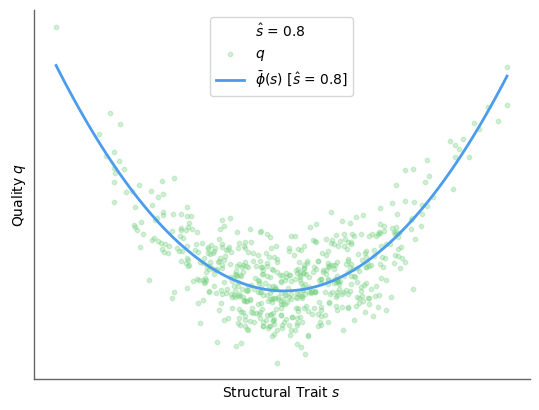

<Figure size 800x600 with 0 Axes>

GenerationResult(s=array([ 0.30340908, -1.5650131 , -0.26910159, ...,  0.86976449,
       -0.59859963, -2.04128873]), q=array([ 4.20499308,  6.81313178,  3.67365742, ...,  3.88864481,
        6.85354831, 12.05871424]), w=array([ 0.15881682, -0.65861131, -0.032643  , ...,  0.70498794,
       -0.1353264 , -1.02266169]), s_prime=array([-0.94471487, -0.3102397 ,  0.7390667 , ..., -0.31857198,
       -0.28718561,  0.05282904]), q_prime=array([5.78413596, 4.56774468, 2.3729977 , ..., 3.53572809, 1.16837205,
       3.25870812]), cov_ws=1.8429036394111783e-07, cov_wq=2.2868648281139607e-09, cov_wq_est_max=2.5550707028963938e-09, rho_sq=0.0036470663153960184, rho_sq_est=0.0035156145510631437, rho_wq=0.0032642336171064892, rho_ws=0.928495877376365, s_hat=0.8, s_hat_est=0.8007263026733921, E_ws=3.685118492415857e-11, E_wq=2.0034092248766634e-08, E_wq_est_lin=7.370236984831714e-11, E_wq_est_phi_bar=2.0386144999415056e-08, delta_s_bar=1.84327215126042e-07, delta_q_bar=2.2320957076880596e-08, ratio_

In [15]:
r = simulate_generation(np.random.normal(0, 1, 1_000_000), s_hat=.8)
display_s_vs_q(r, filename='plot-s-vs-q.pdf')
print(r)

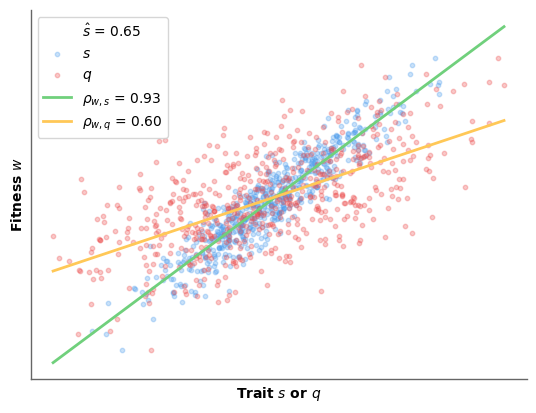

<Figure size 800x600 with 0 Axes>

In [1496]:
r = simulate_generation(np.random.normal(0, 1, 1_000_000), s_hat=.65)
display_sq_vs_w(r, filename='plot-sq-vs-w.pdf')

rho_sq_mean: 0.47801

q rho   : 0.18781
q mean  : 28.94182
q CV    : 3.68667
q ratio : -0.33197

s rho   : 0.31727
s mean  : 13.43673
s CV    : 2.36876
s ratio : -0.37855

QSC      : -0.06235
QSC ratio: -0.10391


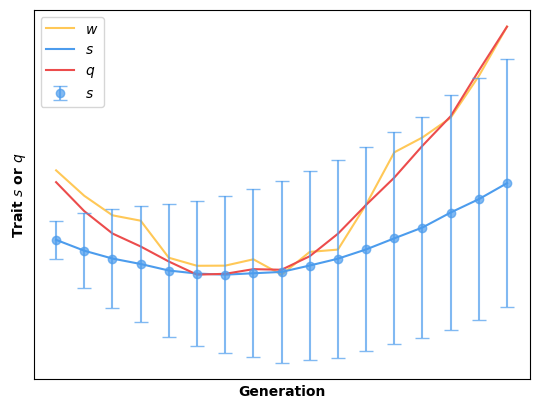

<Figure size 800x600 with 0 Axes>

In [1560]:
gr = simulate_generations(
    generations=50,
    n=10_000,
    s_hat=.6,
    delta_fn=noise(0, -1, 4.7),
    fitness_fn=noise(.1, 0, 10),
)

display_generation(gr, filename="plot-ns-rebound.pdf")

rho_sq_mean: 0.99782

q rho   : -0.20580
q mean  : 183.83881
q CV    : 0.96155
q ratio : -1.63727

s rho   : -0.36917
s mean  : 91.89914
s CV    : 0.58257
s ratio : -0.95447

QSC      : 0.33694
QSC ratio: 0.56157


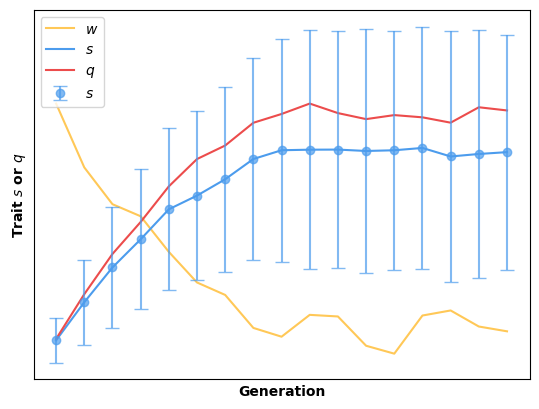

<Figure size 800x600 with 0 Axes>

In [1542]:
gr = simulate_generations(
    generations=50,
    n=1_000,
    s_hat=.6,
    delta_fn=noise(0, 6, 10),
    fitness_fn=noise(-.02, 0, 3),
)

display_generation(gr, filename="plot-ns-inverse.pdf")

rho_sq_mean: 0.97290

q rho   : 0.11443
q mean  : 10.34504
q CV    : 1.13405
q ratio : 0.70829

s rho   : 0.64538
s mean  : 3.52585
s CV    : 0.16726
s ratio : 0.03167

QSC      : 0.08105
QSC ratio: 0.81052


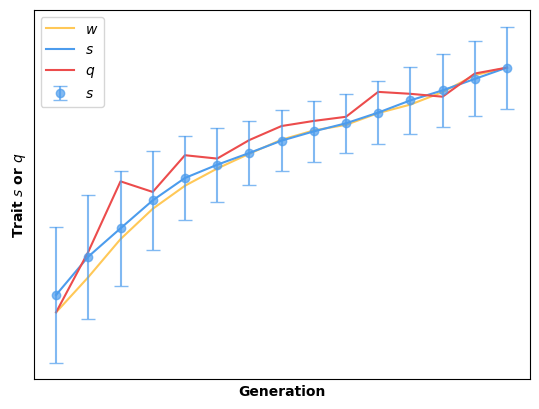

<Figure size 800x600 with 0 Axes>

In [1526]:
gr = simulate_generations(
    generations=30,
    n=1_000,
    s_hat=.1,
    delta_fn=noise(0,  0, .1),
    fitness_fn=noise(1.6, 0, 1.2),
)

display_generation(gr, filename="plot-ns.pdf")

rho_sq_mean: 0.33628

q rho   : 0.01842
q mean  : 11.55194
q CV    : 8.21867
q ratio : -16.30434

s rho   : 0.87782
s mean  : 3.34612
s CV    : 0.08924
s ratio : 0.02048

QSC      : -0.30028
QSC ratio: -50.04633


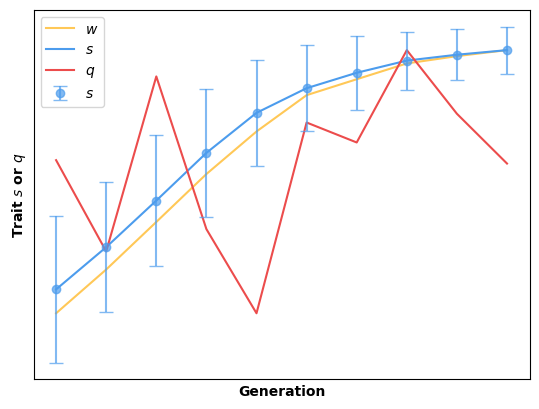

<Figure size 800x600 with 0 Axes>

In [1569]:
gr = simulate_generations(
    generations=20,
    n=1_000,
    s_hat=.006,
    delta_fn=noise(0,  0, .04),
    fitness_fn=noise(.6, 0, .1),
)

display_generation(gr, filename="plot-ns-qsl.pdf")